### Từ tầng kết nối dày đặc đến phép tích chập
- Đến nay, các mô hình ta xem xét đều là các lựa chọn phù hợp nếu dữ liệu đang xử lý có dạng bảng với các hàng tương ứng với các mẫu, còn các cột tương ứng với các đặc trưng.
- Với những dữ liệu có dạng như vậy, ta có thể dự đoán rằng khuôn mẫu mà ta đang tìm kiếm có thể yêu cầu việc mô hình hóa sự tương tác giữa các đặc trưng, nhưng ta __không giả định trước rằng những đặc trưng nào có liên quan tới nhau và mối quan hệ giữa chúng__.
- Đôi khi ta thực sự không có bất kỳ kiến thức nào để định hướng thiết kế các kiến trúc được sắp xếp khéo léo hơn. Trong những trường hợp này, một MLP thường là giải pháp tốt nhất. __Tuy nhiên, khi xử lý dữ liệu tri giác đa chiều, các mạng không có cấu trúc này có thể trở nên quá cồng kềnh__.
- Quay trở lại với ví dụ phân biệt chó và mèo. Giả sử ta đã thực hiện việc thu thập dữ liệu một cách kỹ lưỡng và thu được một bộ ảnh được dán nhãn chất lượng cao với __độ phân giải 1 triệu điểm ảnh__. Điều này nghĩa là đầu vào của mạng sẽ có __1 triệu chiều__. Nếu giảm xuống 1000 chiều ẩn thì sẽ cần một tầng dày đặc có __1 tỷ tham số__. Nếu không có một tập dữ liệu lớn, nhiều gpu, chuyên môn hóa cao trong việc tối ưu phân tán thì việc học các tham số trong mạng này là bất khả thi.

#### 1. Tính bất biến
- Tưởng tượng rằng ta muốn nhận diện một vật thể trong ảnh, sẽ hợp lý nếu cho rằng bất cứ phương pháp nào ta sử dụng đều không nên quá quan tâm đến vị trí chính xác của vật thể trong ảnh.
- Lý tưởng nhất, ta có thể học một hệ thống có khả năng tận dụng được kiến thức này bằng một cách nào đó. Lợn thường không bay và máy bay thường không bơi nhưng tan vẫn có thể nhận ra một con lợn đang bay nếu nó xuất hiện.
- Quay lại với ảnh, ta có những nguyên tắc chính để xây dựng mạng nơ ron cho thị giác máy tính:
    1. Ở một khía cạnh nào đó, các hệ thống thị giác nên phản ứng tương tự với cùng một vật thể đó xuất hiện ở bất kỳ đâu trong ảnh (tính bất biến tịnh tiến)
    2. Ở khía cạnh khác, các hệ thống thị giác nên tập trung vào các khu vực cục bộ và không quan tâm đến bất kỳ thứ gì khác ở xa hơn trong ảnh (tính cục bộ)

#### 2. Phép tích chập cho ảnh
- Toán tử tương quan chéo:
    + Như ta đã biết, tầng tích chập là cái tên không chính xác, vì phép toán chúng biểu diễ là phép tương quan chéo (cross corelation). Trong một tầng tích chập, __một mảng đầu vào và một mảng hạt nhân tương quan kết hợp__ để tạo ra mảng đầu ra bằng phép toán tương quan chéo.
    + Ta tạm thời bỏ qua  chiều kênh và xem phép toán này hoạt động với dữ liệu và biểu diễn ẩn hai chiều. 
    + Trong ảnh, đầu vào là một mảng hai chiều (3, 3). Hạt nhân có kích thước (2, 2). Hạt nhân cũng có thể gọi là hạt nhân tích chập, bộ lọc hay trọng số của tầng.

    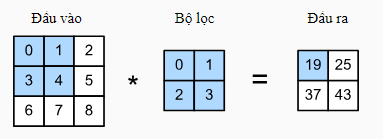
    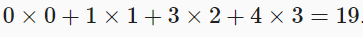

    + Trong phép toán tương quan chéo hai chiều:
        1. Ta bắt đầu với cửa số tích chập đặt tại vị trí góc bên trên trái của mảng đầu vào.
        2. Di chuyển cửa sổ này từ trái sang phải và từ trên xuống dưới. 
        3. Khi cửa sổ tích chập được đẩy tới một vị trí nhất định, mảng con đầu vào nằm trong cửa số đó và mảng hạt nhân được nhân theo từng phần tử rồi ta lấy tổng các phần tử trong mảng kết quả để có được một giá trị số vô hướng duy nhất.
        4. Giá trị này được ghi vào mảng đầu ra tại vị trí tương ứng.
    
    + Lưu ý rằng theo mỗi trục, kích thước đầu ra nhỏ hơn một chút so với đầu vào. Bởi vì hạt nhân có chiều dài và chiều rộng lớn hơn một, ta chỉ có thể tính độ tương quan chéo cho những vị trí mà ở đó hạt nhân nằm hoàn toàn bên trong ảnh.
    + Kích thước đầu ra được tính bằng cách lấy đầu vào H x W trừ kích thước của bộ lọc tích chập h x w bằng (H - h + 1) x (W  - w + 1).
    + Ta có thể giữ nguyên kích thước bằng việc thêm thêm các số 0 xung quanh biên.

In [9]:
from mxnet import gluon, np, npx
from d2l import mxnet as d2l
from mxnet.gluon import nn
npx.set_np()

def cross_correlation(X, K):
    row = X.shape[0] - K.shape[0] + 1
    col = X.shape[1] - K.shape[1] + 1
    output_shape = (row, col)

    output = np.zeros(shape = output_shape)

    for i in range(0, output_shape[0]):
        for j in range(0, output_shape[1]):
            output[i][j] = (X[i:i + K.shape[0], j:j + K.shape[1]] * K).sum()
    return output

X = np.arange(0, 9).reshape(3, 3)
K = np.arange(0, 4).reshape(2, 2)

cross_correlation(X, K), d2l.corr2d(X, K)

(array([[19., 25.],
        [37., 43.]]),
 array([[19., 25.],
        [37., 43.]]))

#### 3. Tầng tích chập
- Tầng tích chập thực hiện phép toán tương quan chéo giữa đầu vào và hạt nhân, sau đó cộng thêm một hệ số điều chỉnh để có được đầu ra. Hai tham số của tầng tích chập là hạt nhân và hệ số điều chỉnh.
- Khi khởi tạo mô hình, ta thường khởi tạo hạt nhân ngẫu nhiên, giống như cách ta làm với tầng kết nối đầy đủ.
- Bây giờ ta đã sẵn sàng lập trình một tầng tích chập hai chiều  dựa vào hàm cross_correlation ta vừa định nghĩa ở trên. Trong hàm khởi tạo __init___, ta khai báo hai tham số của mô hình weight và bias. Hàm tính lượt truyền xuôi forward gọi hàm cross_corre

In [19]:
class Conv2D(nn.Block):
    def __init__(self, kernel_shape, **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape = kernel_shape)
        self.bias = self.params.get('bias', shape = (1, ))
    
    def forward(self, X):
        return cross_correlation(X, self.weight.data()) + self.bias.data() 

layer = Conv2D(kernel_shape=(2, 2))
layer.initialize()
layer(X)

array([[-0.2826936 , -0.4096854 ],
       [-0.66366905, -0.7906608 ]])

#### 4. Phát hiện Biên của vật thể trong ảnh
- Hãy quan sát một ứng dụng đơn giản của tầng tích chập: Phát hiện đường biên của một vật thể trong một bức ảnh bằng cách xác định vị trí các điểm ảnh thay đổi. Đầu tiên, ta dựng một 'bức ảnh' có kích thước là 6x8 điểm ảnh. Bốn cột ở giữa có màu đen (giá trị 0) và các cột còn lại có màu trắng (giá trị 0)

In [20]:
X = np.zeros(shape = (6, 8))
X[:, 0:2] = 1
X[:, 6:8] = 1
X

array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]])

Sau đó, ta tạo một hạt nhân K có kích thước (1, 2). Khi thực hiện phép tương quan chéo với đầu vào, nếu hai phần tử cạnh nhau theo chiều ngang có giá trị giống nhau thì đầu ra sẽ là 0 còn lại thì khác 0.

In [22]:
K = np.array([1, -1]).reshape(1, 2)
Y = cross_correlation(X, K)
Y

array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])